Евгин Александр, 575

evgin.aa@phystech.edu

# Задача 1
**Выборка:** результаты тестирования студентов.

Требуется:

1. Определить, изменились ли **в среднем** результаты тестирования при прохождении курса.
2. Определить размер эффекта по Cohen's d.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as st
import permute.core

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 13

## Загрузка данных и предобработка

In [2]:
data = np.loadtxt('../lab1_data/students.txt', dtype=np.str)
X = pd.DataFrame(data=data[1:], columns=data[0])
X['Score'] = X['Score'].astype('int')

before = np.array(X.loc[X['Time']=='Before'].sort_values(['Student'])['Score'])
after = np.array(X.loc[X['Time']=='After'].sort_values(['Student'])['Score'])

Данные представляем в виде двух массивов *score*-ов, одинаковые индексы в массиве соответствуют одинаковым студентам.

In [305]:
before, after

(array([65, 75, 86, 69, 60, 81, 88, 53, 75, 73]),
 array([ 77,  98,  92,  77,  65,  77, 100,  73,  93,  75]))

## Предварительный обзор выборки

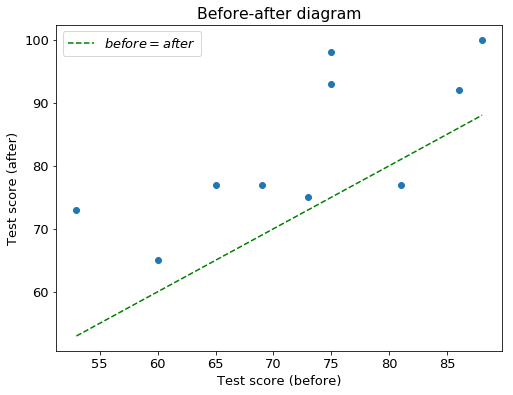

In [306]:
plt.title('Before-after diagram')
plt.xlabel('Test score (before)'), plt.ylabel('Test score (after)')
plt.scatter(before, after)
X = np.linspace(min(before), max(before), 10)
plt.plot(X, X, c='g', linestyle='--', label='$before=after$')
plt.legend()
_ = plt.show()

In [307]:
np.mean(before), np.mean(after)

(72.5, 82.7)

In [308]:
np.median(before), np.median(after)

(74.0, 77.0)

In [309]:
st.mode(before).mode[0], st.mode(after).mode[0]

(75, 77)

Видим, что большая часть точек лежит выше прямой. Это значит, что для большиства студентов *score* увеличился. Кроме того, среднее значение и медиана (и даже мода!) увеличились.

**Предварительный вывод:** курс *эффективный*.

## Нормальность выборок

Для начала, попробуем подойти к решению задачи в предположении о нормальности выборок. Будем рассматривать "приращения" *score*. Убедимся, что такую выборку  можно считать нормальной.

Построим *probability plot*:

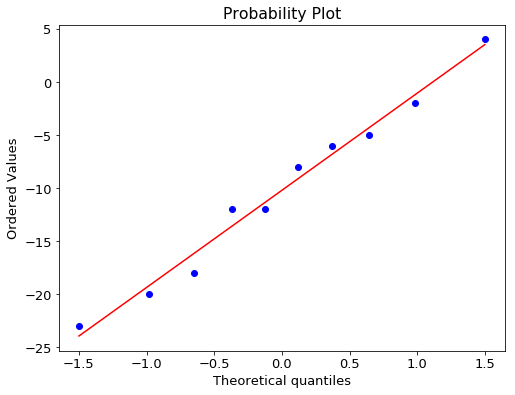

In [15]:
delta = before - after
_ = st.probplot(delta, plot=plt)

Точки в принципе неплохо ложатся на прямую. Проверим нормальность так же с помощью теста Шапиро-Уилка:

In [311]:
W, pvalue = st.shapiro(delta)
pvalue

0.9365940690040588

Видим, что *p-value* выше уровня 0.05 (и вообще достаточно большой), значит гипотезу о нормальности отвергнуть нельзя. Однако стоит взять во внимание размер выборки: **10 измерений** (размер достаточно мал). При таком малом размере в случае более низких *p-value* сказать что-либо было бы нельзя, но здесь мы рискнем.

## t-критерий Стьюдента

Будем полользоваться t-критерием Стьюдента для связанных нормальных выборок. Вопрос задачи интерпретируется как можем ли мы утверждать, что среднее (то есть матожидание), изменилось: $\mu_1 \neq \mu_2$

В этом критерии:

$$
X = (X_1, ..., X_n), \quad Y = (Y_1, ..., Y_n) \\
X_i \sim N(\mu_1, \sigma_1^2), \quad Y_i \sim N(\mu_2, \sigma_2^2)\\
$$
$$
H_0: ~ \mu_1 = \mu_2 \\
H_1: ~ \mu_1 \neq \mu_2
$$
Статистика:
$$
T = \frac{\bar{X} - \bar{Y}}{S/\sqrt{n}}~, \qquad S = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(D_i-\bar{D})^2} \\
D_i = X_i - Y_i, \quad \bar{D} = \frac{1}{n}\sum D_i
$$

In [312]:
T, pvalue = st.ttest_rel(before, after)
pvalue

0.004163495155629837

На стандартном уровне значимости 0.05 гипотезу о равенстве выборок следует отвергнуть. Это значит, что принимается альтернатива, то есть можно утверждать, что **среднее изменилось**.

## Критерий знаковых рангов Уилкоксона

Предположение о нормальности было весьма сильным, поскольку приведенные тесты лучше работают на более объемных выборках. Поэтому проведем другие тесты, не использующие нормальность.

Воспользуемся критерием знаковых рангов Уилкоксона для связанных выборок:

$$
X = (X_1, ..., X_n), \quad Y = (Y_1, ..., Y_n), \quad X_i \neq Y_i \\
$$
$$ 
H_0: ~ med(X - Y) = 0 \\
H_1: ~ med(X - Y) \neq 0
$$
Статистика:
$$
W = \sum_{i=1}^{n}rank(|X_i-Y_i|)~sign(X_i-Y_i)
$$

Можно отметить, что в попарных разностях нет нулей ($X_i \neq Y_i$):

In [27]:
0 in before + after

False

In [28]:
W, pvalue = st.wilcoxon(delta)
pvalue

0.00929822320829811

*p-value* меньше уровня значимости. Таким образом, основная гипотеза отвергается и можно считать, что **среднее изменилось**.

**Проблема:** данный тест рекомендуется использовать для $n>20$. Таким образом, наше решение всё еще не принято окончательно.

## Перестановочный критерий для двух связанных выборок

Используем этот критерий:

$$
X = (X_1, ..., X_n), \quad Y = (Y_1, ..., Y_n), \quad F_X(x) ~ и ~ F_Y(x) ~ симметричны\\
$$
$$ 
H_0: ~ \mathbb{E} (X - Y) = 0 \\
H_1: ~ \mathbb{E} (X - Y) \neq 0
$$
Статистика:
$$
T = \sum_{i=1}^{n}D_i, \quad D_i = X_i - Y_i
$$

Здесь предполагается, что распределения попарных разностей выборок симметричны. Чтобы убедиться в этом, вычислим *skewness*:

In [29]:
st.skew(delta)

0.022254151255959257

Значение достаточно мало, это значит, что можно считать распределение симметричным. Более того, используем предварительную оценку и скажем, что альтернатива - односторонняя (среднее увеличилось). Тогда применим тест:

In [32]:
pvalue, T = permute.core.two_sample(before, after, alternative='less')
pvalue

0.030989999999999962

Таким образом, данный тест тоже принимает альтернативу, а значит и здесь **среднее увеличилось**.

Можно заметить, что если бы не односторонность альтернативы, мы бы получили значние *p-value* больше уровня значимости и не смогли бы отвергнуть гипотезу:

In [34]:
pvalue, T = permute.core.two_sample(before, after, alternative='two-sided')
pvalue

0.062000000000000055

## Размер эффекта Cohen's d

Вычислим размер эффекта Cohen's d:

$$
d = \frac{\bar{X} - \bar{Y}}{s}
$$
$s$ — стандартное отклонение, которое возьмем по определению:
$$
s = \sqrt{\frac{(n_1 - 1) s_1^2 + (n_2 - 1) s_2^2}{n_1 + n_2 - 2}},
$$
где $s_1, s_2$ — выборочные дисперсии.

$n_1=n_2=n$ — размер выборок, в нашем случае.

In [35]:
s1, s2 = np.std(before, ddof=1), np.std(after, ddof=1)
n = len(before)
s = np.sqrt(((n - 1) * s1 ** 2 + (n - 1) * s2 ** 2)/(2 * n - 2))
d = (np.mean(after) - np.mean(before)) / s
d

0.8828678212381178

## Результат

Выборки проанализированы с использованием двух подходов: с использованием *t-критерия Стьюдента* и с использованием *критерия Уилкоксона*. Оба результата дают возможность утверждать, что **среднее значение у выборки изменилось**. Аппелируя к предварительной оценке, можно утверждать, что оно увеличилось: увеличился средний *score* студентов. Таким образом, можно считать курс *эффективным*.

Размер эффекта в метрике Cohen's d составляет ~ ***0.88***